In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

Adaptive Evaluation Step = 1000


In [2]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:10]

In [231]:
class convergence_plotter():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def post(self):
        data = [x for x in self.files]
        
        return data
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.hdf5')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    def walker_perc_plot(self,spec_photo,step=1000, flag = ""):
        import seaborn as sns
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx + 1} walker-percentile plot{flag}')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            #plt.xlim(-10000,None)
            
            colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))            
            for i in range(self.num_walkers):
                y,up_perc,lo_perc = [], [], []
                length = len(sample)//self.num_walkers
                inc = length//step
                x_axis = (np.arange(inc)+1)*step
                for n in range(inc):
                    walker_sample = sample[i:step * (1+n):self.num_walkers]
                    up = np.percentile(walker_sample,84.1)
                    lo = np.percentile(walker_sample,15.9)
                    med = np.median(walker_sample)
                    up_perc.append(up-med)
                    lo_perc.append(med-lo)
                    y.append(med)
                    
                yerr = np.vstack((up_perc,lo_perc))
                plt.plot(x_axis,y,label= f'walker {i+1}',lw = 0.5,c = 'grey')#colors[i])
                plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc),color='gray', alpha=0.05)
                
            plt.savefig(f'Walker-Percentile plot galaxy {idx+1}{flag}.pdf', format = 'pdf')
            plt.show()
    
    def avg_perc_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            y,up_perc,lo_perc = [], [], []
            length = len(sample)
            inc = length//step
            x_axis = (np.arange(inc)+1)*step
            for n in range(inc):
                up = np.percentile(sample[:step*(1+n)],84.1)
                lo = np.percentile(sample[:step*(1+n)],15.9)
                med = np.median(sample[:step*(1+n)])
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            yerr = np.vstack((up_perc,lo_perc))    
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx+1} percentile plot')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            plt.text(length,y[-1],f'{y[-1]}')
            plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
            plt.xlim(-10000,None)
            plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
            plt.show()
    def hist_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal=len(data)
            
        for sample,idx in zip(data,range(num_gal)):
            length = len(sample)
            inc = length//step
            colors = plt.cm.copper_r(np.linspace(0,1,inc))
            plt.figure(figsize=(12,9))
            for n in range(inc):
                hist = plt.hist(sample[:(1+n)*step],bins=50,histtype='step',color=colors[n],density='True',linewidth=1.2)

            plt.xlabel('$log M*$')
            plt.ylabel('Frequency')
            plt.title(f'{spec_photo } galaxy {idx+1} histogram')
            norm = c.Normalize(vmin=1,vmax=length) #Upper and lower boundaries for the color bar
            cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.copper_r))
            plt.show()
                      
        return None
    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF
    
        
    def GRD(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = np.reshape(sample,(M,N))
        means = [] #For E(X)
        sq_means = [] #For E(X^2)

        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))

        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W


        return PSRF

    def PSRF_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot')
            plt.savefig(f'{spec_photo} galaxy {idx+1} PSRF plot.pdf', format = 'pdf')
            plt.show()
            
BFGS = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/BFGS/')
CG = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/CG/')
L_BFGS_B = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/L-BFGS-B/')
Nelder_Mead = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/Nelder-Mead/')
Powell = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/Powell/')
SLSQP = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/SLSQP/')
Nelder_Mead.opener()
SLSQP.opener()
CG.opener()
L_BFGS_B.opener()
Powell.opener()
BFGS.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/Nelder-Mead/Nelder-Mead.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/SLSQP/SLSQP.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/CG/CG.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/L-BFGS-B/L-BFGS-B.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/Powell/Powell.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test/BFGS/BFGS.hdf5']


In [262]:
gal1_mass = input_mass[0]
walker = np.arange(20)+1
def get_init_pos(method,name):
    data = method.post()
    init_pos = data[0]['mcmc_chain'][...][:,0]
    return {name : init_pos}

def plot_resid2(data_list):
    method = []
    mean = []
    for elem in data_list:
        method.append(list(elem.keys())[0])
        mean.append(np.mean(np.abs(list(elem.values())[0]-gal1_mass)))
    x = np.arange(len(method))  # the label locations
    width = 0.40  # the width of the bars
    fig, ax = plt.subplots(figsize=(8,5))
    rects = ax.bar(x, mean, width, color = 'lightblue')
    ax.set_ylabel('Difference')
    ax.set_title('Difference between initial positions and the truth')
    ax.set_xticks(x)
    ax.set_xticklabels(method)

def plot_resid(data):
    fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
    method = list(data.keys())[0]
    pos = list(data.values())[0]
    axs[0].set_title(method)
    axs[0].scatter(walker, pos, label = f'{method}')
    axs[0].set_xticks(np.arange(1,21,1))
    axs[0].set_ylabel('$Log M^*$')
    axs[0].hlines(gal1_mass,xmin=0,xmax=21, color = 'r', linewidth = 1)
    axs[1].plot(walker, np.abs(pos-gal1_mass), label = f'{method}')
    axs[1].set_ylabel('Absolute Residual')
    axs[1].set_xlabel('Walkers')
    fig.subplots_adjust(hspace=0)
    plt.xlim(0,21)
    plt.show()
    
BFGS_pos = get_init_pos(BFGS,'BFGS')
CG_pos = get_init_pos(CG,'CG')
L_BFGS_B_pos = get_init_pos(L_BFGS_B,'L-BFGS-B')
Nelder_Mead_pos = get_init_pos(Nelder_Mead,'Nelder-Mead')
Powell_pos = get_init_pos(Powell,'Powell')
SLSQP_pos = get_init_pos(SLSQP,'SLSQP')
methods_list = [BFGS_pos,CG_pos,L_BFGS_B_pos,Nelder_Mead_pos,Powell_pos,SLSQP_pos]

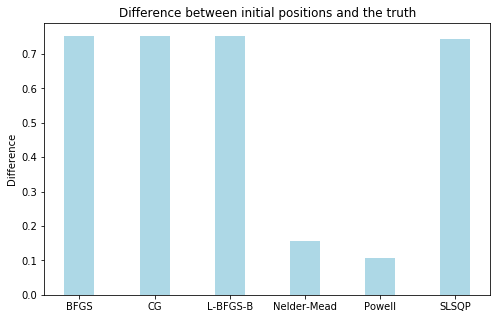

In [264]:
plot_resid2(methods_list)
plt.savefig('Difference.pdf', format = 'pdf')